In [1]:
#%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#these are user defined modules
import plot
import calculate

# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
# CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 1
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2015

# what is this good for??? Not used at the moment
# maybe that was for grouping cohorts differently?
num_years_in_cohort = 1

import warnings
warnings.filterwarnings('ignore')

## Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read authors with start and end year details

In [2]:
# authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-extended.csv')
authorStartEndCareerData.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender,ec_first_auth_3,...,early_career_prod_7,early_career_prod_9,early_career_prod_11,early_career_prod_12,early_career_coauthor_max_hindex_3,early_career_coauthor_max_hindex_5,early_career_coauthor_max_hindex_7,early_career_coauthor_max_hindex_9,early_career_coauthor_max_hindex_11,early_career_coauthor_max_hindex_12
0,'maseka lesaoana,2001,2015,2,15,14,5.0,True,none,0.0,...,1,1,1,1,5.0,5.0,5.0,5.0,5.0,5.0
1,(max) zong-ming cheng,2009,2011,2,3,13,5.0,True,none,0.0,...,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0
2,(zhou) bryan bai,2011,2012,2,2,14,5.0,True,none,2.0,...,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0
3,a aart blokhuis,1992,2005,2,14,13,5.0,True,none,0.0,...,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0
4,a ahrabian,2017,2017,1,1,15,7.5,True,none,0.0,...,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0


#### Career len removal

In [3]:
#print(authorStartEndCareerData.shape)
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData.career_length >= CAREER_LENGTH]
#print(authorStartEndCareerData.shape)


#this is probably not needed but should not harm since we only want to analyze people that started between 1970-2002
years = sorted(authorStartEndCareerData.start_year.unique())
COHORT_START_YEARS = [y for y in years if (y <= (END_YEAR - MAX_CAREER_LENGTH_COHORT)) and (y>=1971)]

authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData.start_year.isin(COHORT_START_YEARS)]
#print(authorStartEndCareerData.shape)
#print(COHORT_START_YEARS)

### Read Citation data (uses paper->author network)

In [4]:
# authorCitationsData = pd.read_csv('derived-data/authors-perYear-citations-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorCitationsData = pd.read_csv('derived-data/authors-perYear-citations.csv')
authorCitationsData.rename(columns={'year_cit':'year', 'cit_count':'num_cit'}, inplace=True)

#### Tests

In [5]:
# 'maseka lesaoana published 2 publications in total, one in 2001 and one in 2015
# for the one is 2015 she did not get yet any citations
authorCitationsData[authorCitationsData["author"] == "'maseka lesaoana"]

,author,year,num_cit
0,'maseka lesaoana,2004.0,1
1,'maseka lesaoana,2005.0,1
2,'maseka lesaoana,2006.0,3
3,'maseka lesaoana,2007.0,1
4,'maseka lesaoana,2008.0,1
5,'maseka lesaoana,2012.0,1
6,'maseka lesaoana,2013.0,1
7,'maseka lesaoana,2015.0,4


In [6]:
authorStartEndCareerData[authorStartEndCareerData["author"] == "'maseka lesaoana"]

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender,ec_first_auth_3,...,early_career_prod_7,early_career_prod_9,early_career_prod_11,early_career_prod_12,early_career_coauthor_max_hindex_3,early_career_coauthor_max_hindex_5,early_career_coauthor_max_hindex_7,early_career_coauthor_max_hindex_9,early_career_coauthor_max_hindex_11,early_career_coauthor_max_hindex_12


In [7]:
# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
authorCitationsData[authorCitationsData["author"] == '(max) zong-ming cheng']

,author,year,num_cit


### Merge citations with authors

In [8]:
authorCitationsData = authorCitationsData.merge(authorStartEndCareerData[['author', 'start_year', 'gender']], on='author')
print(authorCitationsData.shape)

(1888979, 5)


In [9]:
authorCitationsData.head()

,author,year,num_cit,start_year,gender
0,a min tjoa,1996.0,2,1979,none
1,a min tjoa,1997.0,3,1979,none
2,a min tjoa,1998.0,1,1979,none
3,a min tjoa,1999.0,2,1979,none
4,a min tjoa,2000.0,2,1979,none


### Citation distribution after 15 years

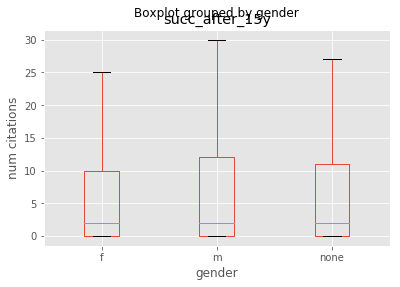

In [10]:
ax = authorStartEndCareerData.boxplot(column='succ_after_15y', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [11]:
groupByYearData = calculate.calculate_cumulative_for_authors(authorCitationsData, 'num_cit')

In [12]:
groupByYearData.head()

,year,author,num_cit,start_year,gender,cum_num_cit
0,1971.0,r. paul,1,1971,none,1
1,1971.0,j. m. sanchez-anton,1,1971,none,1
2,1971.0,h. m. salkin,1,1971,none,1
3,1971.0,dirk van dalen,1,1971,m,1
4,1971.0,gary d. knott,1,1971,none,1


In [13]:
groupByYearData.shape

(1888979, 6)

In [14]:
# years = groupByYearData['year'].unique()
# years = sorted(years)

cohort_start_years = COHORT_START_YEARS

In [15]:
from importlib import reload
reload(plot)
reload(calculate)

<module 'calculate' from '/home/danielkostic/cumulative-advantage/calculate.py'>

#### Tests

In [16]:
# some plausibility checks
print(groupByYearData.head(n=1))
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))

# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
# in 2011 he received 0 citations and after 2013 as well!!!
print(groupByYearData[groupByYearData["author"] == '(max) zong-ming cheng'])

     year   author  num_cit  start_year gender  cum_num_cit
0  1971.0  r. paul        1        1971   none            1
Empty DataFrame
Columns: [year, author, num_cit, start_year, gender, cum_num_cit]
Index: []
Empty DataFrame
Columns: [year, author, num_cit, start_year, gender, cum_num_cit]
Index: []


### Cohort Analysis (Num Cit)

In [17]:
#plot.run_cohort_analysis(authorCitationsData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_cit", "Number of Citations", authorStartEndCareerData, num_years_in_cohort)  

### Cohort Analysis (Cum Num Cit)

get_cohort_careerage_df
start_year: 1971
cohort_size: 981
start_year: 1972
cohort_size: 1207
start_year: 1973
cohort_size: 1400
start_year: 1974
cohort_size: 1830
start_year: 1975
cohort_size: 1599
start_year: 1976
cohort_size: 1996
start_year: 1977
cohort_size: 1929
start_year: 1978
cohort_size: 1907
start_year: 1979
cohort_size: 2352
start_year: 1980
cohort_size: 2458
start_year: 1981
cohort_size: 2817
start_year: 1982
cohort_size: 3262
start_year: 1983
cohort_size: 3721
start_year: 1984
cohort_size: 4668
start_year: 1985
cohort_size: 4821
start_year: 1986
cohort_size: 5857
start_year: 1987
cohort_size: 6624
start_year: 1988
cohort_size: 8364
start_year: 1989
cohort_size: 9293
start_year: 1990
cohort_size: 10871
start_year: 1991
cohort_size: 12429
start_year: 1992
cohort_size: 13769
start_year: 1993
cohort_size: 16375
start_year: 1994
cohort_size: 18390
start_year: 1995
cohort_size: 19201
start_year: 1996
cohort_size: 20803
start_year: 1997
cohort_size: 23234
start_year: 1998
cohort_

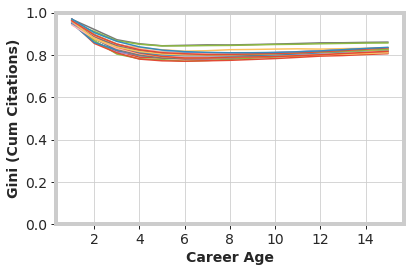

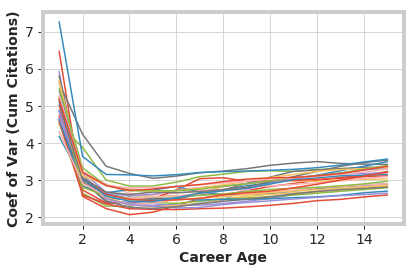

unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
plot_cohort_size_gini_cor fig
plot_cohort_size_gini_cor fig2
plot_cohort_means_over_ages


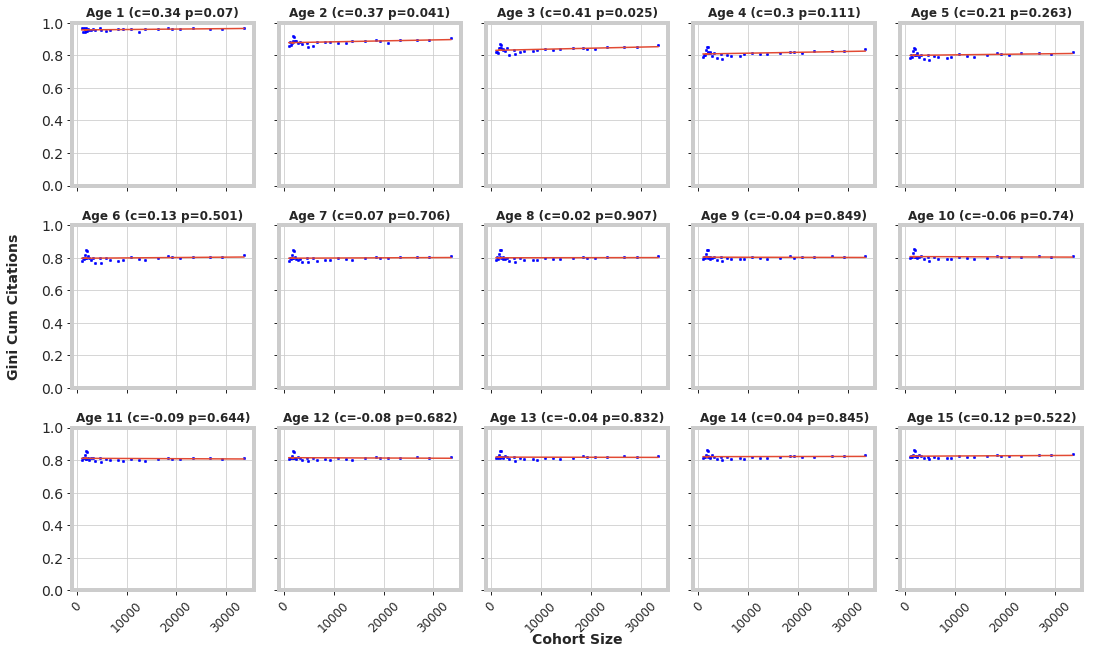

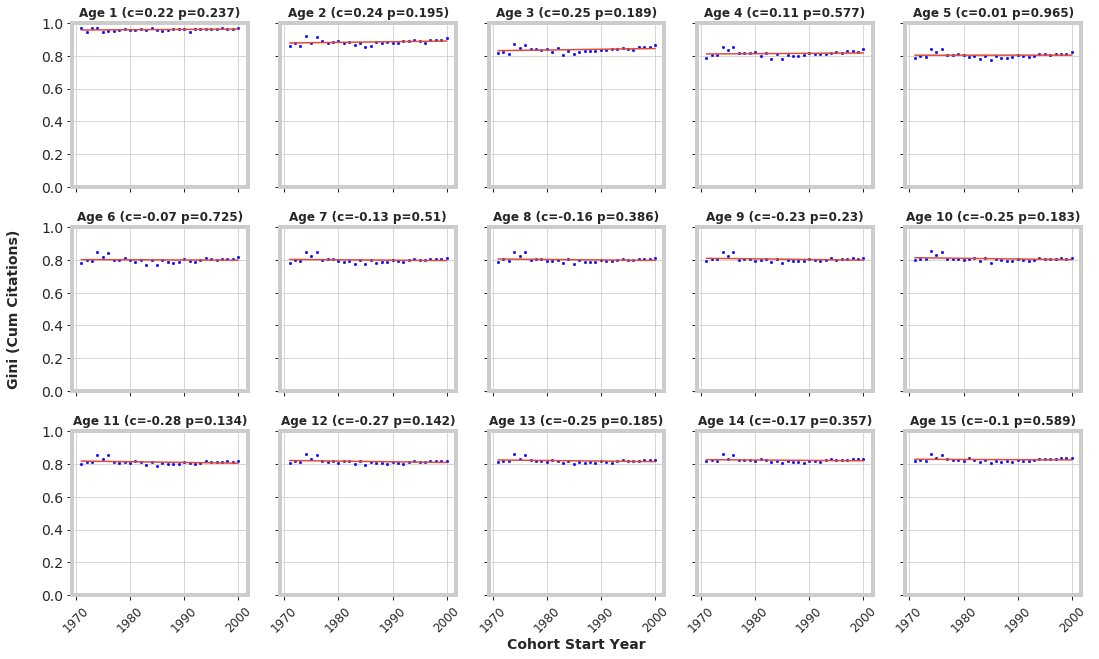

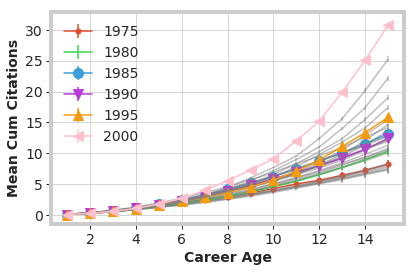

plot_cohort_diffs_over_ages


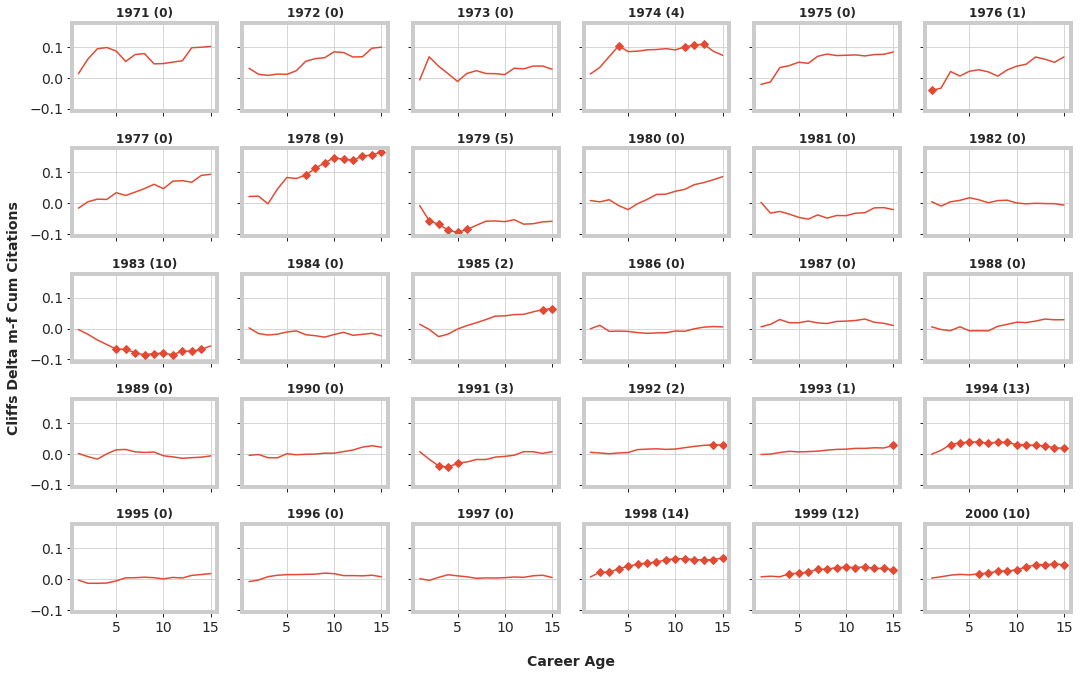

plot_cohort_diffs_over_ages_condensed


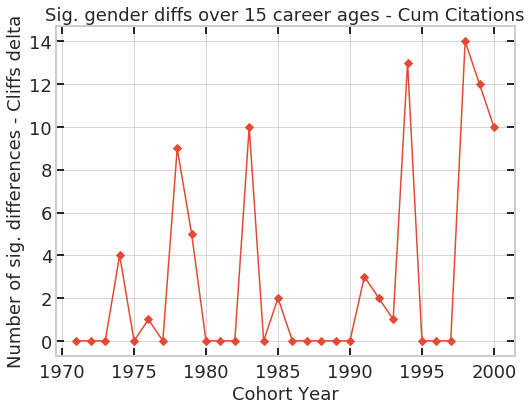

plot_gini_cliff


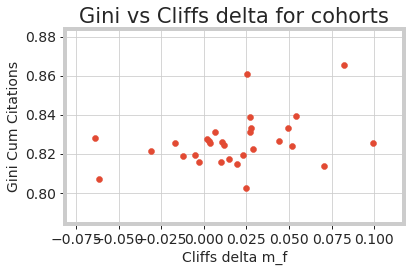

In [18]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, 
                         MAX_CAREER_LENGTH_COHORT, "cum_num_cit", "Cum Citations", authorStartEndCareerData,num_years_in_cohort)  

#### Test run

start_year: 1971
cohort_size: 981
start_year: 1972
cohort_size: 1207
start_year: 1973
cohort_size: 1400
start_year: 1974
cohort_size: 1830
start_year: 1975
cohort_size: 1599
start_year: 1976
cohort_size: 1996
start_year: 1977
cohort_size: 1929
start_year: 1978
cohort_size: 1907
start_year: 1979
cohort_size: 2352
start_year: 1980
cohort_size: 2458
start_year: 1981
cohort_size: 2817
start_year: 1982
cohort_size: 3262
start_year: 1983
cohort_size: 3721
start_year: 1984
cohort_size: 4668
start_year: 1985
cohort_size: 4821
start_year: 1986
cohort_size: 5857
start_year: 1987
cohort_size: 6624
start_year: 1988
cohort_size: 8364
start_year: 1989
cohort_size: 9293
start_year: 1990
cohort_size: 10871
start_year: 1991
cohort_size: 12429
start_year: 1992
cohort_size: 13769
start_year: 1993
cohort_size: 16375
start_year: 1994
cohort_size: 18390
start_year: 1995
cohort_size: 19201
start_year: 1996
cohort_size: 20803
start_year: 1997
cohort_size: 23234
start_year: 1998
cohort_size: 26766
start_year: 

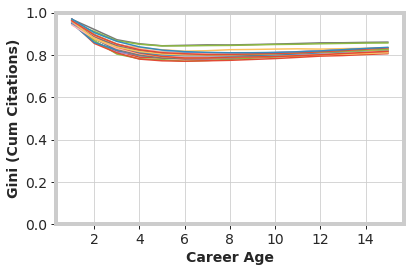

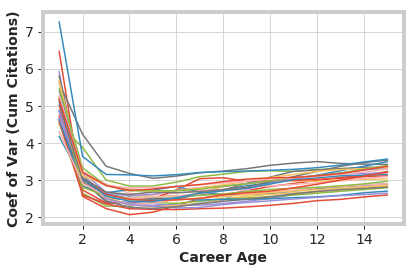

unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
plot_cohort_size_gini_cor fig
plot_cohort_size_gini_cor fig2
plot_cohort_means_over_ages


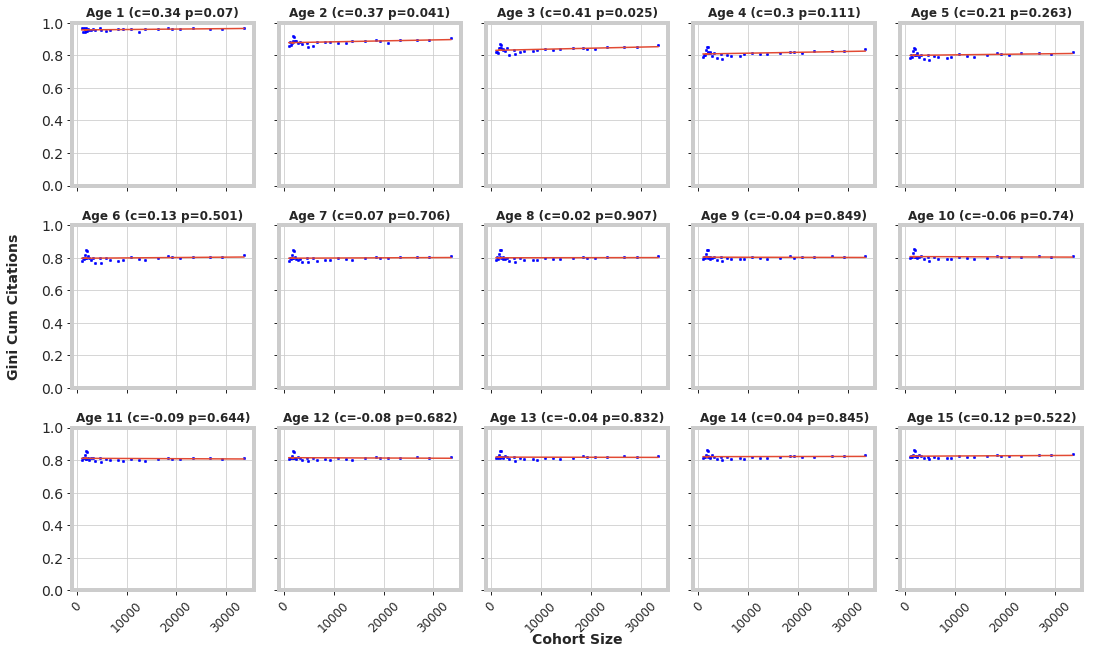

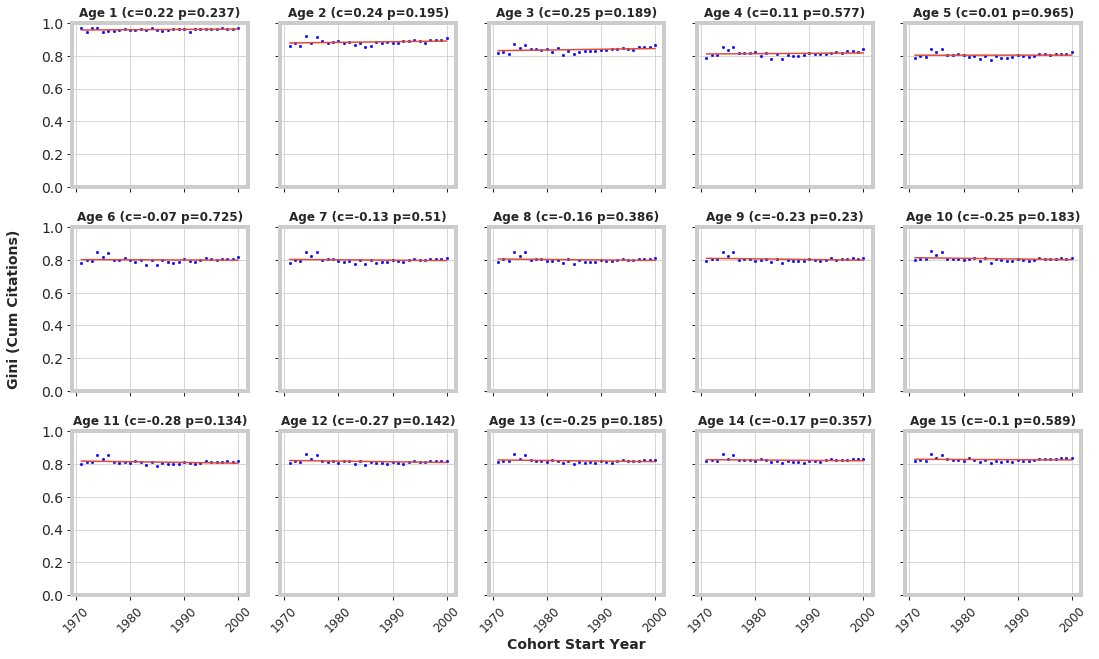

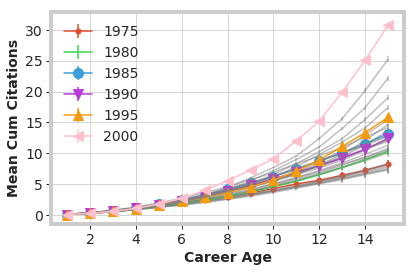

plot_cohort_diffs_over_ages


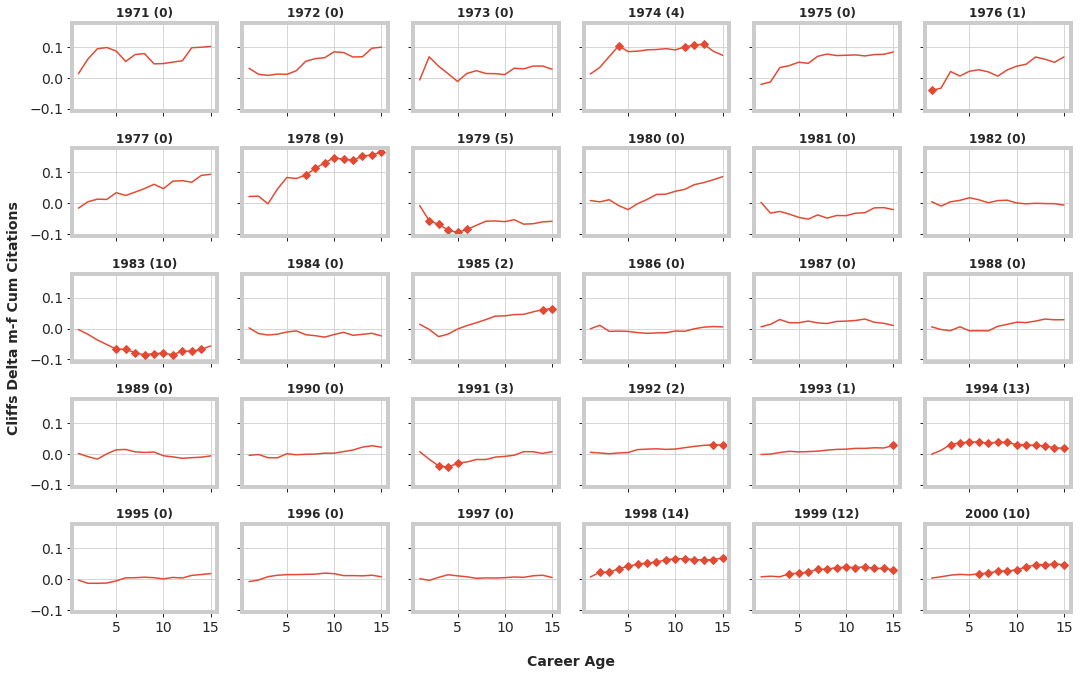

plot_cohort_diffs_over_ages_condensed


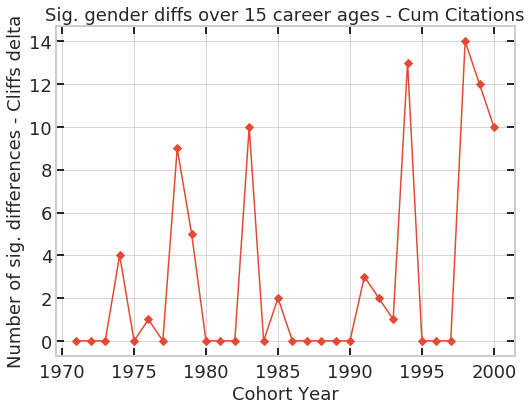

plot_gini_cliff


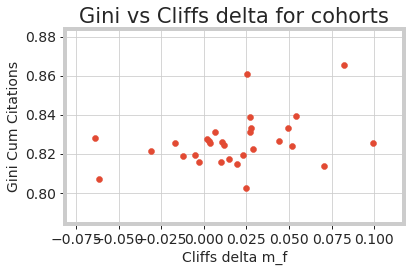

In [19]:
from plot import *

groupByYearData, cohort_start_years, max_career_age_cohort, criterion, criterion_display, authorStartEndCareerData, num_years_in_cohort = groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_cit", "Cum Citations", authorStartEndCareerData,num_years_in_cohort

cohort_careerage_df = get_cohort_careerage_df(groupByYearData, cohort_start_years, max_career_age_cohort, criterion,
                                              authorStartEndCareerData)

# print("num_years_in_cohort: "+str(num_years_in_cohort))

# group cohorts 
if num_years_in_cohort > 1:
    cohort_careerage_df = group_cohorts(cohort_careerage_df, cohort_start_years, num_years_in_cohort)

# gini
cohort_size_gini = get_cohort_size_gini(cohort_careerage_df, criterion,
                                        cohort_careerage_df["cohort_start_year"].unique())
# cohort_size_gini = get_cohort_gini(cohort_careerage_df,criterion, np.array([1970, 1980, 1990, 2000]))

plot_gini(cohort_size_gini, criterion, criterion_display)

plot_cohort_size_gini_cor(cohort_size_gini, criterion, criterion_display)

# effect size and significance - mwu
cohort_effect_size_df = get_cohort_effect_size(cohort_careerage_df)

# mean/std/median
stats = get_cohort_stats(cohort_careerage_df, criterion)

stats = stats.merge(cohort_effect_size_df, on=['cohort_start_year', 'career_age'])

plot_cohort_means_over_ages(stats, criterion, criterion_display)

plot_cohort_diffs_over_ages(stats, criterion, criterion_display)

plot_cohort_diffs_over_ages_condensed(stats, criterion, criterion_display)

plot_gini_cliff(stats, criterion, criterion_display, cohort_size_gini)

In [20]:
stats.columns

Index(['cohort_start_year', 'cohort_size', 'career_age', 'criterion', 'mean',
       'std', 'sem', 'median', 'mean_f', 'median_f', 'std_f', 'sem_f',
       'mean_m', 'median_m', 'std_m', 'sem_m', 'mean_n', 'median_n', 'std_n',
       'sem_n', 'cliffd_m_f', 'values', 'effect', 'statistic', 'pvalue'],
      dtype='object')

In [21]:
cohort = stats[stats["cohort_start_year"] == 2000]
significant_effect = cohort[cohort.pvalue <= 0.05].career_age.values


In [22]:
num_sig_over_cohorts = stats[['cohort_start_year', 'career_age', 'pvalue']]\
    .groupby('cohort_start_year').agg({'pvalue': lambda x: sum(x <= 0.05)})

plot_cohort_diffs_over_ages


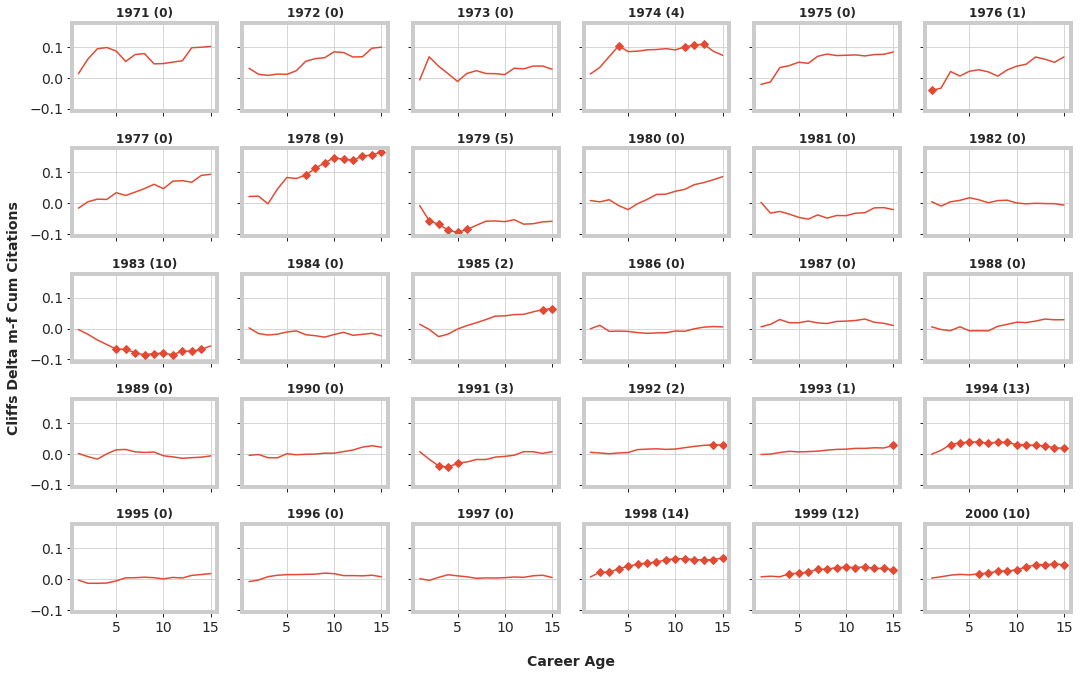

In [23]:
plot_cohort_diffs_over_ages(stats, criterion, criterion_display)

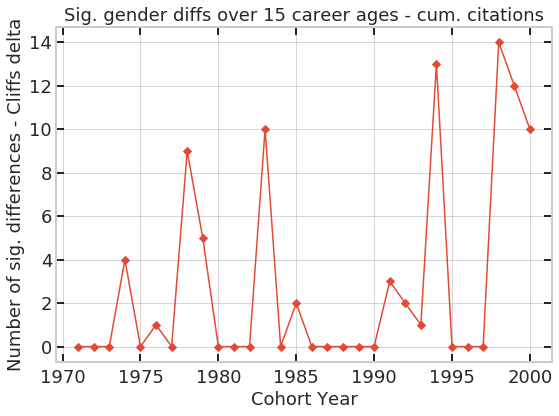

In [24]:
criteria_name = 'Number of sig. differences - Cliffs delta'
title = 'Sig. gender diffs over 15 career ages - cum. citations'
letter = ''
linewidth = 2
fontsize = 18
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

plt.plot(num_sig_over_cohorts, '-D', markevery=True)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xlabel('Cohort Year', fontsize=fontsize)
ax.set_ylabel(f'{criteria_name}', fontsize=fontsize)
ax.set_title(title, fontsize=fontsize)
ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax.spines['left'].set_linewidth(linewidth)
ax.spines['right'].set_linewidth(linewidth)
ax.spines['bottom'].set_linewidth(linewidth)
ax.spines['top'].set_linewidth(linewidth)
plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
fig.savefig("fig/cliffs_delta_" + criterion + "_gender_condensed.png")

### Effect size - TODO

In [25]:
groupByYearData, cohort_start_years, max_career_age_cohort, criterion, criterion_display, authorStartEndCareerData, skip_overlaping_years = authorCitationsData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_cit", "Number of Citations", authorStartEndCareerData, skip_overlaping_years

NameError: name 'skip_overlaping_years' is not defined

In [ ]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, max_career_age_cohort, criterion, authorStartEndCareerData, skip_overlaping_years)

In [ ]:
effect_formula = ['r', 'common_language']

In [ ]:
cohort_effect_size = plot.get_cohort_effect_size(cohort_careerage_df, 'm', 'f', effect_formula[0])
plot.plot_cohort_effect_size(cohort_effect_size, num_significant = 10, effect_formula = effect_formula[0])

In [ ]:
cohort_effect_size.head()

In [ ]:
cohort_effect_size = plot.get_cohort_effect_size(cohort_careerage_df, 'm', 'f', effect_formula[1])
plot.plot_cohort_effect_size(cohort_effect_size, num_significant = 10, effect_formula = effect_formula[1])

#### Tests

In [ ]:
from importlib import reload
reload(plot)

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, 
                                                   "cum_num_cit", authorStartEndCareerData)

#------------------------------------------

In [ ]:
cohort_careerage_df.head()

In [ ]:
subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & 
                              (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & 
                               (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))

# What should i do with the rest of this notebook?

### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

In [ ]:
# cohort_start_years = [1974, 1975, 1976, 1979, 2000]

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'cum_num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'cum_num_cit', 'Cumulative Number of Citations')

### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [ ]:
# _1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1975] 
# _1985Authors.shape

In [ ]:
# _1985Authors.columns

In [ ]:
# _1985Authors.sort_values(by=['num_cit'], axis = 0, ascending=False,inplace=False)

In [ ]:
# _1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
# _1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
# print(_1995_2000_year_1985Authors.shape)
# _1995_2000_year_1985Authors.head(10)

In [ ]:
# temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
# temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
# temp.head()

# #print(temp1['id2'].unique())

In [ ]:
# donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
# donatella

In [ ]:
# plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [ ]:
# authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [ ]:
reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

In [ ]:
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)